In [8]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import time
import json
import random
import numpy as np
import pandas as pd
import itertools
import scipy
import gc

from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import colors as colors_mat
from scipy.ndimage import label, generate_binary_structure
from numpy.lib.stride_tricks import as_strided
from itertools import product
from scipy.spatial.distance import cdist
from scipy.signal import convolve2d
from collections import Counter

In [9]:
start_time = time.time()
print("Load Initial Data ...")

data_path = Path('')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
testing_path = data_path / 'test'

training_tasks = sorted(os.listdir(training_path))
evaluation_tasks = sorted(os.listdir(evaluation_path))
testing_tasks = sorted(os.listdir(testing_path))
submission = pd.read_csv(data_path / 'sample_submission.csv', index_col='output_id')

print("--- %s seconds ---" % (time.time() - start_time))

Load Initial Data ...
--- 0.011596918106079102 seconds ---


In [10]:
start_time = time.time()
print("Load Data Functions ...")

def flattener(pred):
    
    str_pred = str([row for row in pred.tolist()])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    
    return str_pred

def load_data(p, phase=None):
    
    if phase in {'training', 'test', 'evaluation'}:
        p = data_path / phase / p
    
    task = json.loads(Path(p).read_text())
    dict_vals_to_np = lambda x: { k : np.array(v) for k, v in x.items() }
    assert set(task) == {'test', 'train'}
    res = dict(test=[], train=[])
    
    for t in task['train']:
        assert set(t) == {'input', 'output'}
        res['train'].append(dict_vals_to_np(t))
    for t in task['test']:
        res['test'].append(dict_vals_to_np(t))
        
    return res

print("--- %s seconds ---" % (time.time() - start_time))

Load Data Functions ...
--- 0.0009441375732421875 seconds ---


In [11]:
start_time = time.time()
print("Load Data Files ...")

train_task_data = []
for i in range(0, 400):
    task = load_data(training_tasks[i], phase='training')
    list.append(train_task_data, task)

eval_task_data = []
for i in range(0, 400):
    task = load_data(evaluation_tasks[i], phase='evaluation')
    list.append(eval_task_data, task)

test_task_data = []
for i in range(0, 100):
    task = load_data(testing_tasks[i], phase='test')
    list.append(test_task_data, task)
    
print("--- %s seconds ---" % (time.time() - start_time))

Load Data Files ...
--- 0.40566134452819824 seconds ---


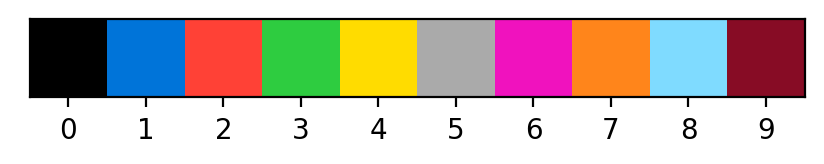

In [12]:
cmap = colors_mat.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors_mat.Normalize(vmin=0, vmax=9)

num2color = ["black", "blue", "red", "green", "yellow", "gray", "magenta", "orange", "sky", "brown"]
color2num = {c: n for n, c in enumerate(num2color)}

plt.figure(figsize=(5, 2), dpi=200)
plt.imshow([list(range(10))], cmap=cmap, norm=norm)
plt.xticks(list(range(10)))
plt.yticks([])
plt.show()

def plot_one(task, ax, i,train_or_test,input_or_output):
    input_matrix = task[train_or_test][i][input_or_output]
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
    ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
    ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])     
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(train_or_test + ' '+ input_or_output)
    
def plot_task(task):
    """
    Plots all the train and test pairs of a specified task,
    using same color scheme as the ARC app
    """    
    num_train = len(task['train'])
    fig, axs = plt.subplots(2, num_train, figsize=(3*num_train,3*2))
    for i in range(num_train):     
        plot_one(task, axs[0,i],i,'train','input')
        plot_one(task, axs[1,i],i,'train','output')        
    plt.tight_layout()
    plt.show()        
        
    num_test = len(task['test'])
    fig, axs = plt.subplots(2, num_test, figsize=(3*num_test,3*2))
    if num_test==1: 
        plot_one(task, axs[0],0,'test','input')
        plot_one(task, axs[1],0,'test','output')     
    else:
        for i in range(num_test):      
            plot_one(task, axs[0,i],i,'test','input')
            plot_one(task, axs[1,i],i,'test','output')  
    plt.tight_layout()
    plt.show()